# Time series Basics
- 전통적인 시계열 모델의 다양한 개념과 몇 가지 basic intuition의 결합
---
1. 목표
    - 초보자를 위한 다양한 시계열 개념의 저장소 역할을 하기 위해 만들었다.
2. 목차
     - 1) Competition and data overview
     - 2) Imports
     - 3) EDA
     - 4) 단일 시계열
         - Stationarity
         - Seasonality , Trend and Remainder
         - AR , MA , ARMA , ARIMA
         - Selecting P and Q using AIC
         - ETS
         - Prophet
         - UCM
     - 5) 계층적 시계열
         - Bottom's up
         - AHP
         - PHA
         - FP

## 1) Competition and data overview
- 이번 대회 과제는 러시아 소프트웨어 기업의 다음 달 모든 제품과 매장의 총 매출을 예측하는 것이다.
- 이 회사는 일상적인 기업 활동을 자동화하는 프로그램을 만듭니다.
- 데이터: 우리는 일일 매출 데이터를 제공받지만 월별 매출을 예측해야 한다.

## 2) Imports

In [4]:
# 항상 파일들부터 체크하며 시작해라.
print(os.listdir("./input/"))

['items.csv', 'item_categories.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


In [5]:
# 기본 패키지들 설치
import numpy as np
import pandas as pd
import random as rd
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

#시계열 관련 패키지들 설치
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#추가 세팅
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 데이터 가져오기 
sales=pd.read_csv("./input/sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("./input/item_categories.csv")
item=pd.read_csv("./input/items.csv")
sub=pd.read_csv("./input/sample_submission.csv")
shops=pd.read_csv("./input/shops.csv")
test=pd.read_csv("./input/test.csv")
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


## 3) EDA

In [6]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

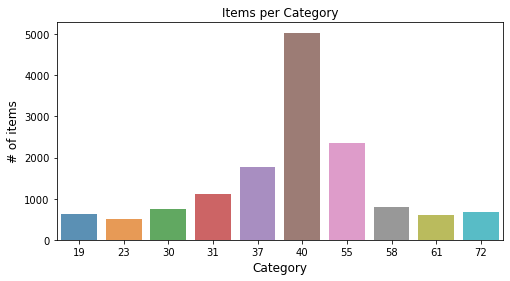

In [7]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

- 이 데이터 세트에서는 다른 내용보다 시계열 부분을 집중적으로 살피자.

## 4) 단일 시계열
- 목표는 store-item 조합에서 다음 달 매출을 예측하는 것이다.
- 각 스토어의 시간별 매출은 그 자체로 시계열이다. 
- 모든 조합을 살피기 전에 단일 열을 예측하자.
- 회사 전체의 월 총 매출을 예측하기로 했으므로 먼저 월별 총 매출을 계산하고 데이터를 그래프로 표시하자.

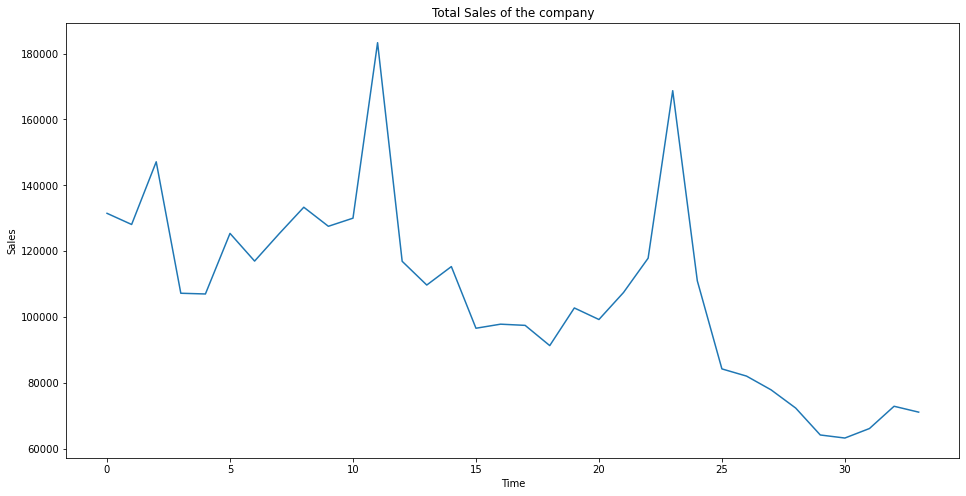

In [8]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

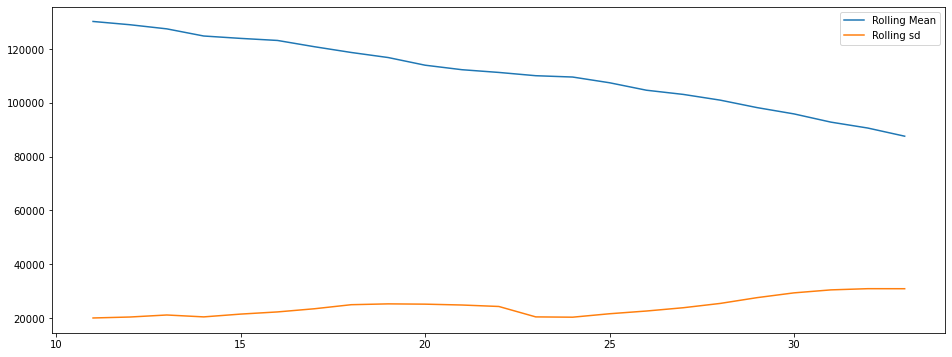

In [9]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

- seasonality에 감소하는 추세가 있다.
- Trend, seasonality, residuals 로 빠르게 분해하는 방법을 알아보자.

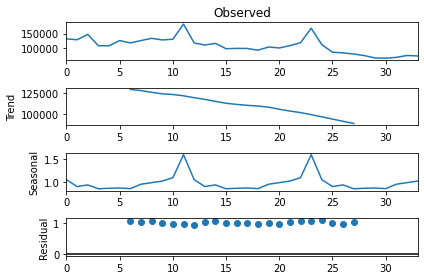

In [10]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

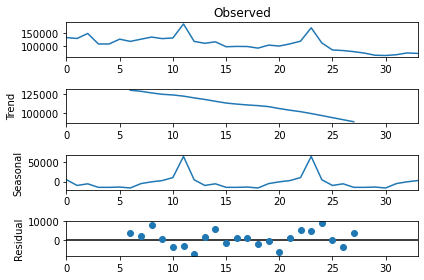

In [11]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

- 우리는 additive 모델을 가정하고 yt=St+Tt+Et 이렇게 쓸 수 있다.
- yt는 기간 t의 데이터
- St는 기간 t의 계절 성분
- Tt는 기간 t의 추세 주기 성분
- Et는 기간 t의 나머지(또는 불규칙 또는 오류) 성분이다.
- Multiplicative model로는 yt=St x Tt x Et

#### 4-1.Stationarity 
- Stationarity 는 시계열의 시간 불변성을 나타낸다. 
- 즉, 시계열의 두 점은 방향이 아니라 얼마나 떨어져 있는지에 따라 서로 관련되어 있다.
- 시계열이 정지해 있으면 모형화하기 더 쉽다. 보통 모델링 할때 시계열이 정지 상태라고 가정한다.
- Stationarity 를 확인하는 여러 가지 테스트가 있다.
    - ADF, KPSS, PP
- 가장 많이 사용되는 ADF만 수행할 것이다.

In [12]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


[]

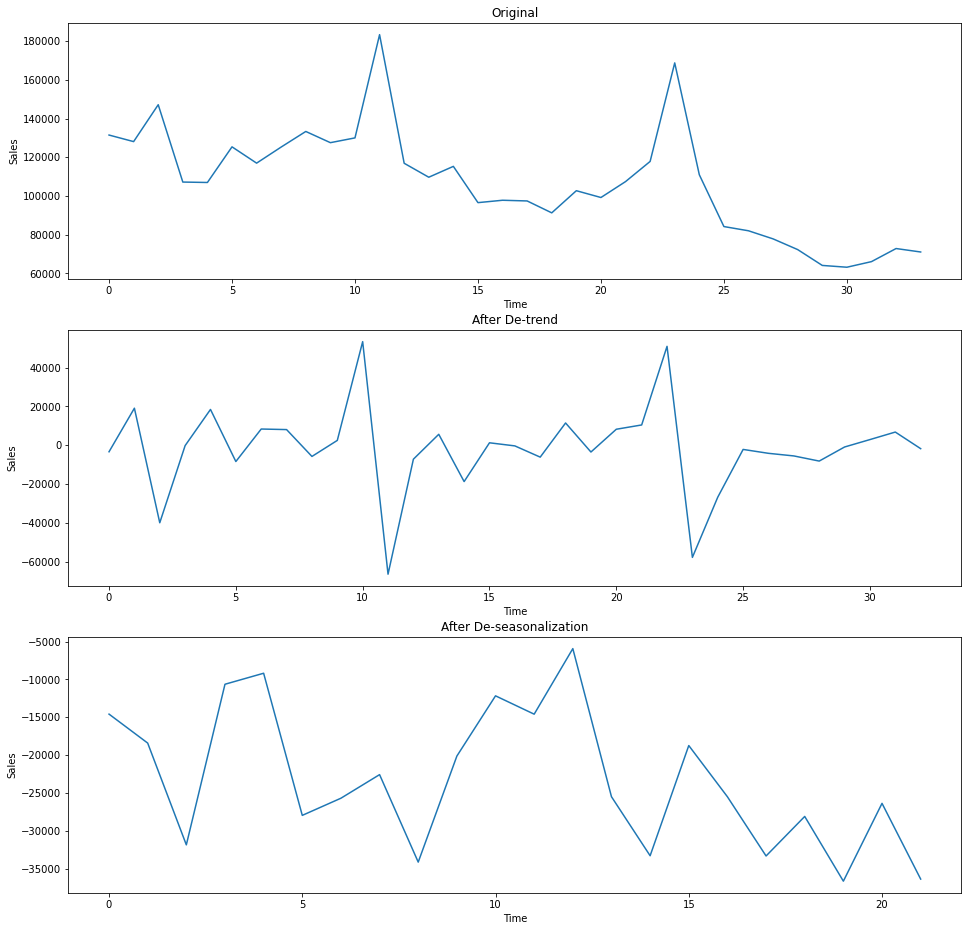

In [13]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [14]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


- 변환 후 DF검정의 p값은 5%이내이다. 따라서 우리는 series의 stationarity를 가정할 수 있다.
- 위에서 정의한 역변환 함수를 사용하여 original series를 구할 수 있다.
- 예측을 시작해보자!

#### 4-2. AR, MA and ARMA models
- MA: series의 다음 값은 이전 n개의 값 AR의 평균 함수이다.
- 다음 값의 오차는 이전 n개 값 ARMA의 에러 함수이다.
- 둘을 혼합해라.
- AR 과정이나 MA 과정 중에 시계열이 있는지 어떻게 확인할 수 있을까?

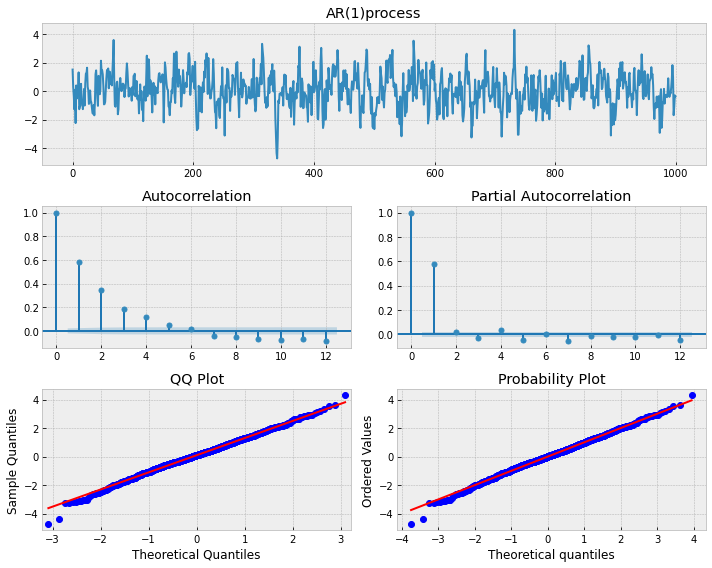

In [15]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

#### AR(1) process에서 ACF tailing out 그리고 PACF가 lag=1에서 차단됨.

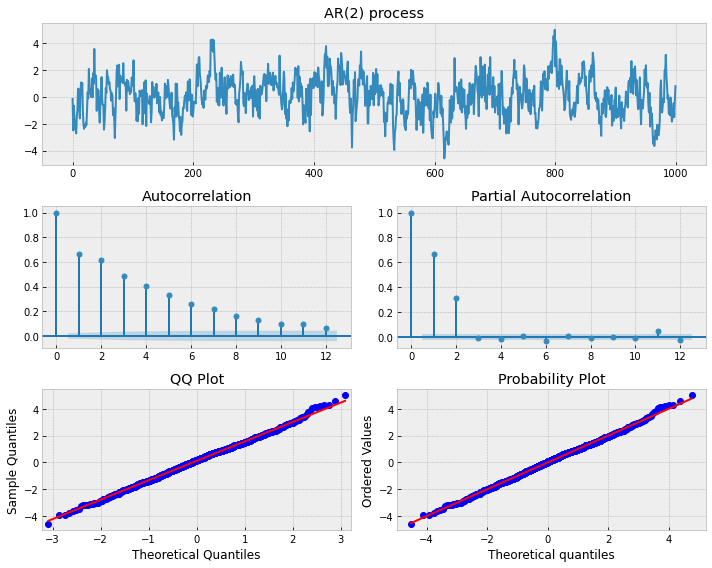

In [16]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

#### AR(2) process에서 ACF tailing out 그리고 PACF가 lag=2에서 차단됨.

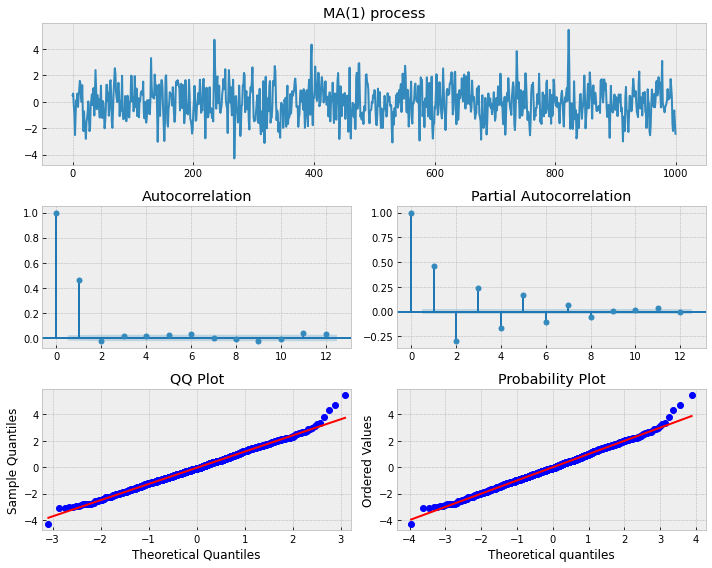

In [17]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

#### MA(1) process는 lag=1에서 ACF가 차단됨.

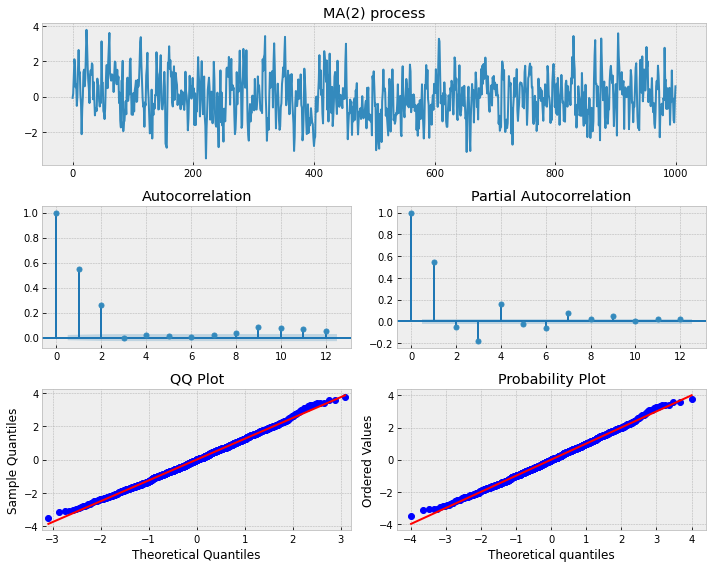

In [18]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

#### MA(2) process는 lag=2에서 ACF가 차단됨.

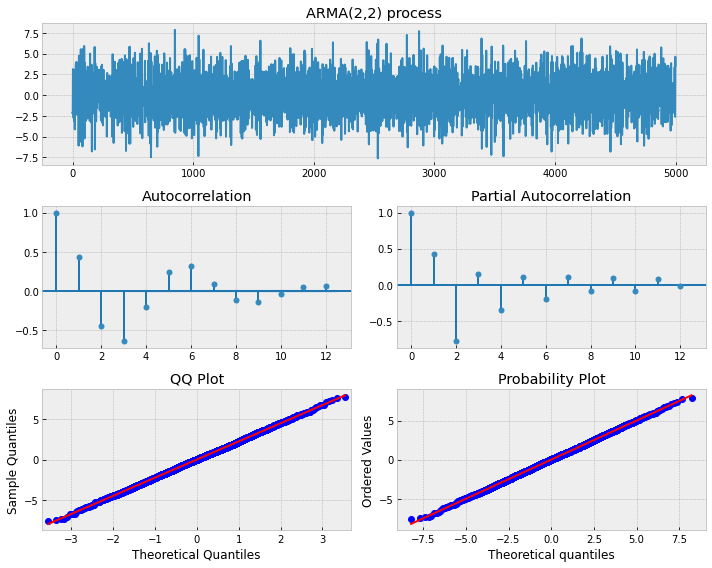

In [19]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

- 매우 명확하지 않다.
- AR,MA 프로세스의 순서를 찾기 위해 체계적인 접근을 이용하자

In [20]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


- simulated process의 순서를 ARMA(2,2)로 확인했다.
- 판매 시계열에 이용하자.

In [21]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [22]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


#### Prophet
- 이것은 매우 유망한 도구이고 편리하고 빠른 해결책이다.
- 적절한 사전처리와 신중한 매개변수 조절이 그래프 오류를 줄일 것이다.
- 기본적인 prophet 절차는 다음의 네 가지 성분을 가진 additive 회귀 모델이다.
    - 부분 선형, 로지스틱 성장 곡선 trend
    = 푸리에 급수를 이용하여 연간 계절 성분을 모델링
    - 더미 변수를 사용하는 주간 계절 성분
    - 사용자가 제공한 중요한 휴일 목록

In [1]:

from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

model.plot(forecast)

In [ ]:
model.plot_components(forecast)

- prophet 의 trend와 seasonality는 우리가 이전에 전통적인 방법을 사용한 결과와 비슷하다.

### 5) Hierarchical time series
- The Forecasting: principles and practice 이 책 좋다. 그룹화된 예측이나 계층적 예측을 다루는 기본 사항을 제시한다.
- 이 책에서 계층구조의 점들을 추정하기 위해 다음과 같은 방식들을 제안한다.
1. Bottom up approach
    - 원하는 방법을 사용하여 모든 기본 수준 열을 예측한 다음 맨 위로 집계한다.
    - 장점: 단순하다. 집계로 인해 정보가 손실되지 않는다.
    - 단점: 낮은 레벨은 노이즈가 있을 수 있다.
2. Top down approach
    - 최상위 수준을 먼저 예측한다. 예) 총 판매량 먼저 예측.
    - 그 다음 총 매출에 대한 품목 매출의 기여도를 base level로 예측에 제공해야하는 총 매출의 비율을 나타내는 가중치를 계산.
    - 가중치 계산에도 다양한 방법이 있다.
        - Average Historical Proportions: 지난 몇 달동안 품목이 매출에 기여한 단순 평균
        - Proportion of historical averages: bottom series의 평균 값과 총 series의 평균 값의 비율
        - Forecasted Proportions: 과거의 비율 변화를 사용하여 미래의 비율을 예측
3. Middle out
    - bottom up과 top down 방법을 같이 사용해라.
    - 상점-항목 수준 예측하는 문제라면, 중간 수준의 상점을 가지고 상점에 대한 예측값을 찾아라. 그리고 bottoms up 방식을 이용해여 전체 판매량을 파악하고 비율을 사용하여 top-down approach를 사용하여 품목 레벨의 판매를 찾아낸다.(??)
4. 최적의 접근방식 조합
    - 모든 layer에 대해 독립적으로 예측.
    - 모든 layer가 독립이므로 계층과 일치하지 않을 수 있다.
    - 예시) 품목은 독립적으로 예측되기 때문에 상점에서 판매되는 품목의 합계가 상점의 예상 판매량과 같지 않을 수 있다.
    - 일부 행렬 계산이나 조정은 계층과 일치하도록 예측에 임시조정을 제공한다.

- 이제 예측을 시작하자.
- 이 문제는 22170개의 item과 60개의 store를 가지고 있다. 이는 예측해야하는 개별 시계열(item-store 조합)이 약 백만개임을 나타낸다.
- 각각 구성하는것은 불가능하기 때문에 우리는 prophet을 이용한다.
- bottom up 부터 시작한다.
- 다음을 고려하자.
    - 모든 스토어가 모든 품목을 판매하는 것은 아니다.
    - 신제품이 출시되면 어떻게 되는가?
    - 제품이 진열대에서 사라지면 어떻게 되는가?

In [ ]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

In [ ]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

In [ ]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break

- 10개의 예측이 16초정도 걸렸다. 우리는 100만개의 예측이 필요하므로 이 방법으로는 조금 힘들다.

### 5-2. Middle out

In [ ]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

In [ ]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

In [ ]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)
predictions_unknown=predictions[-1]
predictions_unknown